<a href="https://colab.research.google.com/github/AndresMontesDeOca/Laboratorio3/blob/main/TimeSeriesSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
#############################################################################
def normalize_data(df, normalization="MinMax"):
    """
    Normaliza cada serie de tiempo (columna) de manera individual usando MinMax o Zscore.

    Args:
        df (pd.DataFrame): DataFrame con series de tiempo de distintos productos, cada columna es un producto.
        normalization (str): Tipo de normalización a aplicar. Opciones: "MinMax" o "Zscore". Default es "MinMax".

    Returns:
        normalized_df (pd.DataFrame): DataFrame con las series normalizadas.
        normalization_params (pd.DataFrame): DataFrame con los parámetros necesarios para desnormalizar cada columna.
            - Para "MinMax": valores min y max de cada columna.
            - Para "Zscore": valores mean y std de cada columna.
    """
    normalization_params = pd.DataFrame(columns=["product_id", "min", "max", "mean", "std"])
    normalized_df = pd.DataFrame(index=df.index)

    for column in df.columns:
        if normalization == "MinMax":
            scaler = MinMaxScaler()
            normalized_values = scaler.fit_transform(df[[column]]).flatten()
            new_params = pd.DataFrame({
                "product_id": [column],
                "min": [scaler.data_min_[0]],
                "max": [scaler.data_max_[0]],
                "mean": [None],
                "std": [None]
            })
            normalization_params = pd.concat([normalization_params, new_params], ignore_index=True)
            normalized_df[column] = normalized_values

        elif normalization == "ZScore":
            scaler = StandardScaler()
            normalized_values = scaler.fit_transform(df[[column]]).flatten()
            new_params = pd.DataFrame({
                "product_id": [column],
                "min": [None],
                "max": [None],
                "mean": [scaler.mean_[0]],
                "std": [scaler.scale_[0]]
            })
            normalization_params = pd.concat([normalization_params, new_params], ignore_index=True)
            normalized_df[column] = normalized_values

        else:
            raise ValueError("Invalid normalization method. Choose 'MinMax' or 'ZScore'.")

    return normalized_df, normalization_params
#############################################################################
def denormalize_series(normalized_series, normalization_params, normalization="MinMax"):
    """
    Desnormaliza una serie de tiempo usando los valores almacenados.

    Args:
        normalized_series (pd.Series or pd.DataFrame): Serie o DataFrame con los datos normalizados.
        normalization_params (pd.DataFrame): DataFrame con los parámetros necesarios para desnormalizar cada serie o columna.
            - Para "MinMax": valores min y max de cada serie o columna.
            - Para "Zscore": valores mean y std de cada serie o columna.
        normalization (str): Tipo de normalización a deshacer. Opciones: "MinMax" o "Zscore". Default es "MinMax".

    Returns:
        denormalized_series (pd.Series or pd.DataFrame): Serie o DataFrame con los datos desnormalizados.
    """
    if isinstance(normalized_series, pd.DataFrame):
        denormalized_df = pd.DataFrame(index=normalized_series.index)
        for column in normalized_series.columns:
            params = normalization_params[normalization_params["product_id"] == column]
            if normalization == "MinMax":
                min_value = params["min"].values[0]
                max_value = params["max"].values[0]
                denormalized_values = normalized_series[column] * (max_value - min_value) + min_value
            elif normalization == "ZScore":
                mean_value = params["mean"].values[0]
                std_value = params["std"].values[0]
                denormalized_values = normalized_series[column] * std_value + mean_value
            else:
                raise ValueError("Invalid normalization method. Choose 'MinMax' or 'ZScore'.")
            denormalized_df[column] = denormalized_values
        return denormalized_df
    elif isinstance(normalized_series, pd.Series):
        product_ids = normalized_series.index
        denormalized_values = []
        for product_id in product_ids:
            params = normalization_params[normalization_params["product_id"] == product_id]
            if normalization == "MinMax":
                min_value = params["min"].values[0]
                max_value = params["max"].values[0]
                denormalized_value = normalized_series[product_id] * (max_value - min_value) + min_value
            elif normalization == "ZScore":
                mean_value = params["mean"].values[0]
                std_value = params["std"].values[0]
                denormalized_value = normalized_series[product_id] * std_value + mean_value
            else:
                raise ValueError("Invalid normalization method. Choose 'MinMax' or 'ZScore'.")
            denormalized_values.append(denormalized_value)
        denormalized_series = pd.Series(denormalized_values, index=product_ids, name=normalized_series.name)
        return denormalized_series
    else:
        raise TypeError("normalized_series should be either a pandas Series or DataFrame")
#############################################################################
def split_data(df):
  df_train = df.loc['1987':'1988']
  df_valid = df.loc['1989']
  return df_train, df_valid
#############################################################################
def windowed_dataset(sequence, data_split, window_size, horizon, batch_size, shuffle_buffer=1000):
    """Generates dataset windows.

    Args:
      sequence (array-like): Contains the values of the time series.
      data_split (str): Specifies if the dataset is for training or validation/test.
      window_size (int): The number of time steps to include in the feature.
      horizon (int): The number of future time steps to predict.
      batch_size (int): The batch size.
      shuffle_buffer (int): Buffer size to use for the shuffle method.

    Returns:
      tf.data.Dataset: TF Dataset containing time windows.
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(sequence)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + horizon, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + horizon))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-horizon], window[-horizon:]))

    if data_split == 'train':
        # Shuffle the training data to improve generalization
        dataset = dataset.shuffle(shuffle_buffer)
    else:
        # Cache the validation/test data for improved performance
        dataset = dataset.cache()

    # Create batches of windows and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset
#############################################################################
def compile_model(new_model, loss, optimizer):
    new_model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    print(new_model.summary())
    return new_model
#############################################################################
def MyModel(loss, optimizer, window_size, horizon, n_features):
    new_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((window_size, n_features)),
        # tf.keras.layers.Conv1D(filters=window_size +  horizon, kernel_size=3, activation='relu', padding='causal'),
        # tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(n_features * horizon, activation='relu'),
        tf.keras.layers.Reshape((horizon, n_features)),
    ])
    return compile_model(new_model, loss, optimizer)
#############################################################################
def MyCallbacks(patience):
    """
    Devuelve una lista de callbacks para el entrenamiento del modelo.

    Parameters:
    patience (int): Número de épocas a esperar para ver una mejora en 'val_loss' antes de detener el entrenamiento.

    Returns:
    list: Lista de callbacks de Keras.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return [early_stop]
#############################################################################
def plot_history(history, start_epoch=0, metrics=None):
    if isinstance(metrics, str):
        metrics = [metrics]

    if metrics is None:
        metrics = [x for x in history.history.keys() if x[:4] != 'val_']

    if len(metrics) == 0:
        print('No metrics to display.')
        return

    # Get the epochs and filter them starting from start_epoch
    x = history.epoch[start_epoch:]

    rows = 1
    cols = len(metrics)
    count = 0

    plt.figure(figsize=(12 * cols, 8))

    for metric in sorted(metrics):
        count += 1
        plt.subplot(rows, cols, count)
        plt.plot(x, history.history[metric][start_epoch:], label='Train')
        val_metric = f'val_{metric}'
        if val_metric in history.history.keys():
            plt.plot(x, history.history[val_metric][start_epoch:], label='Validation')
        plt.title(metric.capitalize())
        plt.legend()
    plt.show()
################################################################

<Axes: xlabel='Date'>

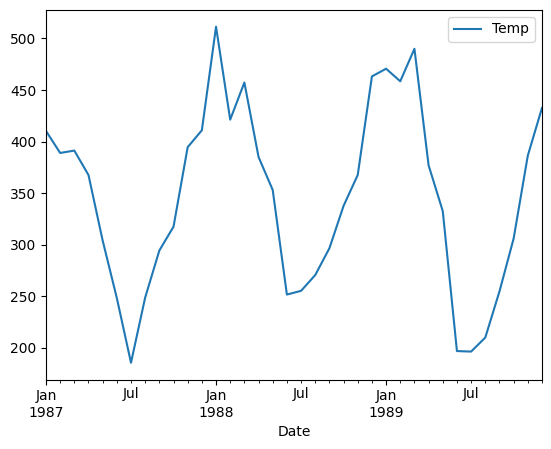

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar la serie temporal de temperaturas diarias de Nueva York
data_raw = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')

# Convertir la columna 'Date' a tipo datetime y establecerla como índice
data_raw['Date'] = pd.to_datetime(data_raw['Date'])
data_raw.set_index('Date', inplace=True)

# Agrupar por mes y calcular la sumatoria de la temperatura
data = data_raw.resample('M').sum()

# Ajustar el índice para que sea el primer día del mes
data.index = data.index.to_period('M').to_timestamp()

data = data.loc['1987':'1989']

data.plot()

In [53]:
normalization = 'MinMax'
window_size = 6
horizon = 2
batch_size = 32



patience = 3
epochs = 20

data_norm, data_norm_params = normalize_data(data, normalization=normalization)
data_norm_train, data_norm_valid = split_data(data_norm)
data_train_wrangled = windowed_dataset(data_norm_train, 'train', window_size, horizon, batch_size)
data_valid_wrangled = windowed_dataset(data_norm_valid, 'valid', window_size, horizon, batch_size)


<Axes: xlabel='Date'>

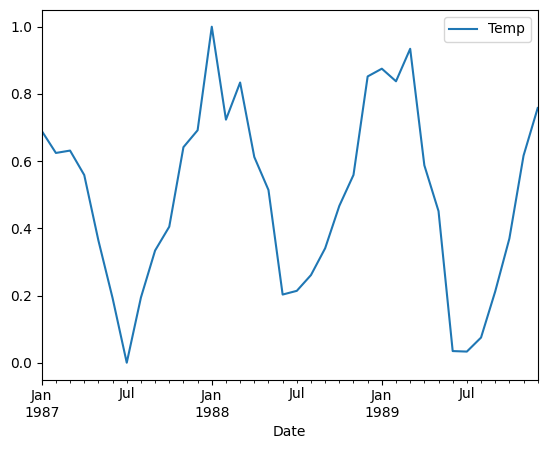

In [54]:
data_norm.plot()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirect  (None, 6, 64)             8704      
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 32)                10368     
 ional)                                                          
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
 reshape_7 (Reshape)         (None, 2, 1)              0         
                                                                 
Total params: 19138 (74.76 KB)
Trainable params: 19138

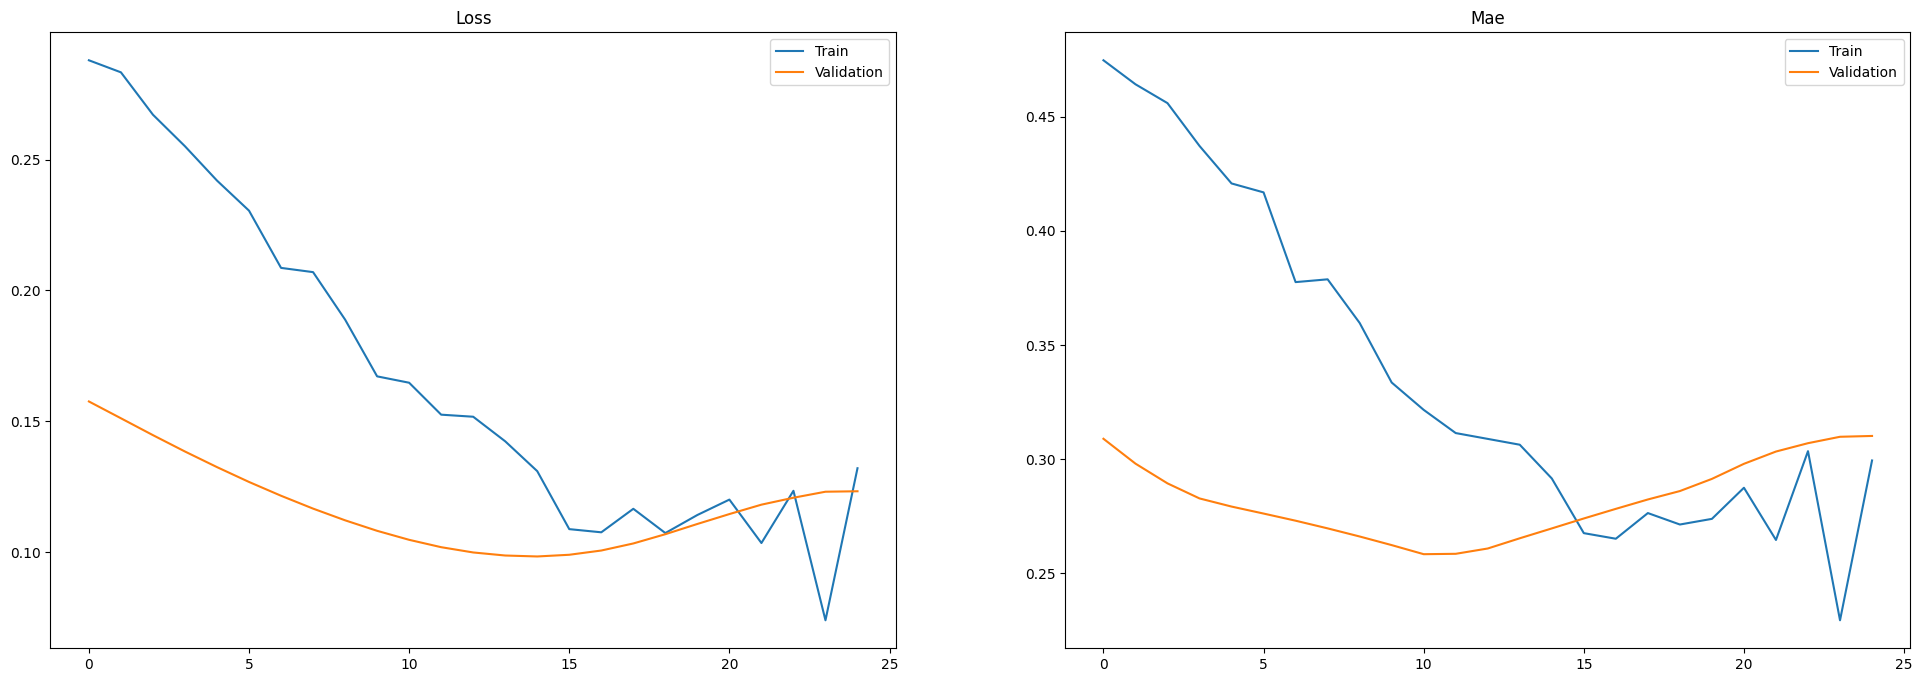

In [55]:
model_name = 'TimeSeries'
loss = 'mse'
optimizer = 'adam'
n_features = data.shape[1]
patience = 10
epochs = 500

callbacks = MyCallbacks(patience)
model = MyModel(loss, optimizer, window_size, horizon, n_features)

history = model.fit(
    data_train_wrangled,
    validation_data = data_valid_wrangled,
    epochs=epochs,
    verbose=0,
    callbacks = callbacks)

plot_history(history)

In [56]:
input_data = data_norm[-window_size:].values.reshape((1, window_size, n_features))
input_data

array([[[0.03314917],
        [0.07489257],
        [0.21209331],
        [0.36955187],
        [0.61632904],
        [0.75813382]]])

In [57]:
input_data2 = data_norm.loc['1989-05':'1989-10'].values.reshape((1, window_size, n_features))
input_data2

array([[[0.45119705],
        [0.03468386],
        [0.03314917],
        [0.07489257],
        [0.21209331],
        [0.36955187]]])

In [58]:
model.predict(input_data2)

1/1 [==============================] - 2s 2s/step


array([[[0.20535383],
        [0.18424323]]], dtype=float32)

In [62]:
data_norm.iloc[-2:]

,Temp
Date,
1989-11-01,0.616329
1989-12-01,0.758134
